In [13]:
import os
import sys
import numpy as np
import pandas as pd
from numpy import random as npr

import torch 

from plotly import graph_objects as go
import plotly.io as pio


import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams['text.usetex'] = True

module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

## 1. Data initialization

In [ ]:
MATRIX_SIZE = 3
USERS_COUNT = 250
ITEMS_COUNT = 100

SEED = 2022
REAL_DATASET_SAMPLE_SIZE = 0.05
CACHE_DIR = "./cache"
SYNTHETIC_USERS_COUNT = 250
SYNTHETIC_ITEMS_COUNT = 100
SAMPLE_SIZES = [0.1, 0.3, 0.5, 0.9]
ALPHA_SAMPLE_RATE = 20
CTGAN_EPOCHS = 10
npr.seed(SEED)

In [3]:
#means of distributions
users_mean = np.random.rand(MATRIX_SIZE)
items_mean = np.random.rand(MATRIX_SIZE)

#covariance matrix for distrubutions
users_cov = np.random.rand(MATRIX_SIZE, MATRIX_SIZE)
users_cov = np.dot(users_cov, users_cov.transpose())


items_cov = np.random.rand(MATRIX_SIZE, MATRIX_SIZE)
items_cov = np.dot(items_cov, items_cov.transpose())


In [4]:
#create data frames
users = pd.DataFrame(np.random.multivariate_normal(users_mean, users_cov, USERS_COUNT) * 
                     np.random.laplace(loc = 1 + np.random.rand(), scale = np.random.rand(), size = (USERS_COUNT, MATRIX_SIZE)) 
                     , columns = ['user_' + str(i) for i in range(MATRIX_SIZE)])
users['user_id'] = [i for i in range(USERS_COUNT)]

items = pd.DataFrame(np.random.multivariate_normal(items_mean, items_cov, ITEMS_COUNT) *
                     np.random.lognormal(mean = np.random.rand(), sigma = np.random.rand(), size = (ITEMS_COUNT, MATRIX_SIZE)),
                     columns = ['item_' + str(i) for i in range(MATRIX_SIZE)])
items['item_id'] = [i for i in range(ITEMS_COUNT)]

users['_merge_key'] = 1
items['_merge_key'] = 1

#merge data frames
df_merge = pd.merge(users, items, on="_merge_key")
df_merge = df_merge.drop(["_merge_key"], axis=1)

In [5]:
users_matrix = np.asarray(df_merge.drop(['user_id', 'item_id'], axis = 1).iloc[:, 0:MATRIX_SIZE] )
items_matrix = np.asarray(df_merge.drop(['user_id', 'item_id'], axis = 1).iloc[:, MATRIX_SIZE:])

In [6]:
#calculation product and scalar product of vectors
product = users_matrix * items_matrix
scal_product = []
for i in product:
    scal_product.append(np.sum(i))
scal_product = np.asarray(scal_product)

In [7]:
#calculation of vectors length
user_len = []
for i in users_matrix:
    user_len.append(np.sqrt(np.sum(i * i)))
user_len = np.asarray(user_len)
    
item_len = []
for i in items_matrix:
    item_len.append(np.sqrt(np.sum(i * i)))
item_len = np.asarray(item_len)


In [8]:
#normalazed cos sim of vectors as response
cos_sim_norm = 1 - np.arccos(scal_product/(user_len * item_len))/np.pi

In [9]:
df_merge['rating'] = cos_sim_norm

## Generate synthetic data 

In [10]:
real_dataset = df_merge.sample(frac=REAL_DATASET_SAMPLE_SIZE)
real_dataset = real_dataset.reset_index(drop=True)

deep_fm = df_merge.copy()
df_deepfm = deep_fm.reset_index(drop=True)

In [11]:
users_df = users.drop(['_merge_key', 'user_id'], axis = 1)
items_df = items.drop(['_merge_key', 'item_id'], axis = 1)

In [14]:
from sdv.tabular import CTGAN, GaussianCopula, CopulaGAN
import time

def fit_and_evaluate_models(df, models, sample_size, file_name, eval_kwargs):
    result = pd.DataFrame()
    for name, model in models.items():
        start = time.time()
        model.fit(df)
        model.save('./validation_models/' + str(name) + '_' + file_name + '.pkl')
        end = time.time()
        print("Fitting of " + name)
        print(end - start)
        eval_result = evaluate(df, model.sample(sample_size), **eval_kwargs)
        eval_result["model_name"] = name
        eval_result["time"] = end-start
        result = pd.concat([result, eval_result])
        
    return result

In [16]:
from sdv.evaluation import evaluate

_comp_result = fit_and_evaluate_models(
    df=users_df,
    models={"GaussianCopula": GaussianCopula(), 
        "CTGAN": CTGAN(verbose=True), "CopulaGAN": CopulaGAN(verbose=True)},
    sample_size=1_000,
    file_name = 'users',
    eval_kwargs={"aggregate": False}
)

/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:4798: RuntimeWarning: divide by zero encountered in true_divide
  return c**2 / (c**2 - n**2)
/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:547: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:4789: RuntimeWarning: divide by zero encountere

Fitting of GaussianCopula
0.8486144542694092


/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/sdmetrics/column_pairs/statistical/kl_divergence.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data[pd.isna(real_data)] = 0.0
/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/pandas/core/frame.py:3093: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)
/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/sdmetrics/column_pairs/statistical/kl_divergence.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

Epoch 1, Loss G:  0.0743, Loss D: -0.0617
Epoch 2, Loss G:  0.1367, Loss D: -0.0113
Epoch 3, Loss G:  0.1543, Loss D:  0.0163
Epoch 4, Loss G:  0.1250, Loss D: -0.0116
Epoch 5, Loss G:  0.1284, Loss D: -0.0099
Epoch 6, Loss G:  0.1431, Loss D: -0.0350
Epoch 7, Loss G:  0.1351, Loss D:  0.0319
Epoch 8, Loss G:  0.1342, Loss D:  0.0449
Epoch 9, Loss G:  0.1456, Loss D:  0.0807
Epoch 10, Loss G:  0.1321, Loss D:  0.0840
Epoch 11, Loss G:  0.1563, Loss D:  0.0418
Epoch 12, Loss G:  0.1090, Loss D:  0.0693
Epoch 13, Loss G:  0.1051, Loss D:  0.0826
Epoch 14, Loss G:  0.1279, Loss D:  0.1644
Epoch 15, Loss G:  0.0397, Loss D:  0.1503
Epoch 16, Loss G:  0.0918, Loss D:  0.1398
Epoch 17, Loss G:  0.0567, Loss D:  0.1914
Epoch 18, Loss G:  0.0838, Loss D:  0.1929
Epoch 19, Loss G:  0.0254, Loss D:  0.2151
Epoch 20, Loss G:  0.0554, Loss D:  0.2328
Epoch 21, Loss G:  0.0536, Loss D:  0.1912
Epoch 22, Loss G:  0.0354, Loss D:  0.1574
Epoch 23, Loss G:  0.0307, Loss D:  0.2280
Epoch 24, Loss G:  0

/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/sdmetrics/column_pairs/statistical/kl_divergence.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data[pd.isna(real_data)] = 0.0
/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/pandas/core/frame.py:3093: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)
/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/sdmetrics/column_pairs/statistical/kl_divergence.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

Epoch 1, Loss G: -0.1764, Loss D:  0.0561
Epoch 2, Loss G: -0.1581, Loss D:  0.0538
Epoch 3, Loss G: -0.1821, Loss D:  0.0257
Epoch 4, Loss G: -0.1729, Loss D:  0.0189
Epoch 5, Loss G: -0.1748, Loss D:  0.0326
Epoch 6, Loss G: -0.2004, Loss D:  0.0506
Epoch 7, Loss G: -0.2062, Loss D:  0.0252
Epoch 8, Loss G: -0.2270, Loss D: -0.0128
Epoch 9, Loss G: -0.2054, Loss D:  0.1109
Epoch 10, Loss G: -0.2650, Loss D:  0.0490


/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


Epoch 11, Loss G: -0.2669, Loss D:  0.0342
Epoch 12, Loss G: -0.2657, Loss D:  0.0794
Epoch 13, Loss G: -0.3024, Loss D:  0.0342
Epoch 14, Loss G: -0.3048, Loss D:  0.0260
Epoch 15, Loss G: -0.3140, Loss D:  0.0302
Epoch 16, Loss G: -0.3352, Loss D:  0.0272
Epoch 17, Loss G: -0.3398, Loss D:  0.0753
Epoch 18, Loss G: -0.3790, Loss D:  0.0927
Epoch 19, Loss G: -0.3878, Loss D:  0.1054
Epoch 20, Loss G: -0.3711, Loss D: -0.0391
Epoch 21, Loss G: -0.4192, Loss D:  0.0816
Epoch 22, Loss G: -0.3957, Loss D: -0.0168
Epoch 23, Loss G: -0.4403, Loss D:  0.0266
Epoch 24, Loss G: -0.4746, Loss D: -0.0411
Epoch 25, Loss G: -0.4913, Loss D: -0.0401
Epoch 26, Loss G: -0.4672, Loss D: -0.0315
Epoch 27, Loss G: -0.5698, Loss D: -0.0112
Epoch 28, Loss G: -0.4822, Loss D:  0.0492
Epoch 29, Loss G: -0.5186, Loss D: -0.0617
Epoch 30, Loss G: -0.4750, Loss D:  0.0052
Epoch 31, Loss G: -0.5281, Loss D: -0.1588
Epoch 32, Loss G: -0.4590, Loss D: -0.0778
Epoch 33, Loss G: -0.5772, Loss D: -0.1399
Epoch 34, L

/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/sdmetrics/column_pairs/statistical/kl_divergence.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data[pd.isna(real_data)] = 0.0
/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/pandas/core/frame.py:3093: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)
/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/sdmetrics/column_pairs/statistical/kl_divergence.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

In [17]:
_comp_result_ = fit_and_evaluate_models(
    df=items_df,
    models={"GaussianCopula": GaussianCopula(), 
        "CTGAN": CTGAN(verbose=True), "CopulaGAN": CopulaGAN(verbose=True)},
    sample_size=1_000,
    file_name = 'items',
    eval_kwargs={"aggregate": False}
)

/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:547: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:4798: RuntimeWarning: divide by zero encountered in true_divide
  return c**2 / (c**2 - n**2)
/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:4789: RuntimeWarning: divide by zero encountere

Fitting of GaussianCopula
0.6183311939239502


/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/sdmetrics/column_pairs/statistical/kl_divergence.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data[pd.isna(real_data)] = 0.0
/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/pandas/core/frame.py:3093: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)
/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/sdmetrics/column_pairs/statistical/kl_divergence.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

Epoch 1, Loss G:  0.0110, Loss D: -0.0149
Epoch 2, Loss G:  0.0054, Loss D: -0.0392
Epoch 3, Loss G:  0.0123, Loss D:  0.0008
Epoch 4, Loss G:  0.0061, Loss D: -0.0347
Epoch 5, Loss G:  0.0191, Loss D: -0.0244
Epoch 6, Loss G: -0.0066, Loss D: -0.0537
Epoch 7, Loss G: -0.0003, Loss D: -0.0700
Epoch 8, Loss G:  0.0332, Loss D: -0.0702
Epoch 9, Loss G: -0.0154, Loss D: -0.0584
Epoch 10, Loss G: -0.0313, Loss D: -0.1043
Epoch 11, Loss G: -0.0481, Loss D: -0.0944
Epoch 12, Loss G: -0.0668, Loss D: -0.0461
Epoch 13, Loss G: -0.0664, Loss D: -0.0758
Epoch 14, Loss G: -0.0946, Loss D: -0.0890
Epoch 15, Loss G: -0.0711, Loss D: -0.0798
Epoch 16, Loss G: -0.1246, Loss D: -0.0944
Epoch 17, Loss G: -0.1251, Loss D: -0.1080
Epoch 18, Loss G: -0.1496, Loss D: -0.1381
Epoch 19, Loss G: -0.1586, Loss D: -0.0785
Epoch 20, Loss G: -0.2027, Loss D: -0.1248
Epoch 21, Loss G: -0.1894, Loss D: -0.1569
Epoch 22, Loss G: -0.2315, Loss D: -0.0693
Epoch 23, Loss G: -0.2863, Loss D: -0.1532
Epoch 24, Loss G: -0

/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/sdmetrics/column_pairs/statistical/kl_divergence.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data[pd.isna(real_data)] = 0.0
/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/pandas/core/frame.py:3093: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)
/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/sdmetrics/column_pairs/statistical/kl_divergence.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

Epoch 1, Loss G:  0.0335, Loss D:  0.0169
Epoch 2, Loss G:  0.0332, Loss D:  0.0234
Epoch 3, Loss G:  0.0435, Loss D: -0.0200
Epoch 4, Loss G:  0.0758, Loss D:  0.0370
Epoch 5, Loss G:  0.0726, Loss D:  0.0335
Epoch 6, Loss G:  0.0684, Loss D:  0.0253
Epoch 7, Loss G:  0.0344, Loss D:  0.0185
Epoch 8, Loss G:  0.0743, Loss D:  0.0868
Epoch 9, Loss G:  0.0964, Loss D:  0.0584
Epoch 10, Loss G:  0.0585, Loss D:  0.0946
Epoch 11, Loss G:  0.0491, Loss D:  0.0294
Epoch 12, Loss G:  0.0719, Loss D:  0.0606
Epoch 13, Loss G:  0.1418, Loss D:  0.0821
Epoch 14, Loss G:  0.1226, Loss D:  0.1088
Epoch 15, Loss G:  0.1529, Loss D:  0.0657
Epoch 16, Loss G:  0.1572, Loss D:  0.1831
Epoch 17, Loss G:  0.1362, Loss D:  0.1359
Epoch 18, Loss G:  0.1863, Loss D:  0.0142
Epoch 19, Loss G:  0.2119, Loss D:  0.1175
Epoch 20, Loss G:  0.2279, Loss D:  0.0932
Epoch 21, Loss G:  0.2371, Loss D:  0.0367
Epoch 22, Loss G:  0.2873, Loss D:  0.0075
Epoch 23, Loss G:  0.2861, Loss D:  0.0109
Epoch 24, Loss G:  0

/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/sdmetrics/column_pairs/statistical/kl_divergence.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data[pd.isna(real_data)] = 0.0
/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/pandas/core/frame.py:3093: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)
/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/sdmetrics/column_pairs/statistical/kl_divergence.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

In [18]:
rs = _comp_result[
    (_comp_result.metric == "LogisticDetection") |
    (_comp_result.metric == "SVCDetection") |
    (_comp_result.metric == "KSTest") 
]

In [19]:
rs=rs.append(pd.DataFrame({'metric' : ['FitTime']*3, 
                        'raw_score' : [0.9518033195586475, 0.4455153260508047, 0.6026813543905478],
                        'model_name' : ['GaussianCopula', 'CTGAN', 'CopulaGAN']}))

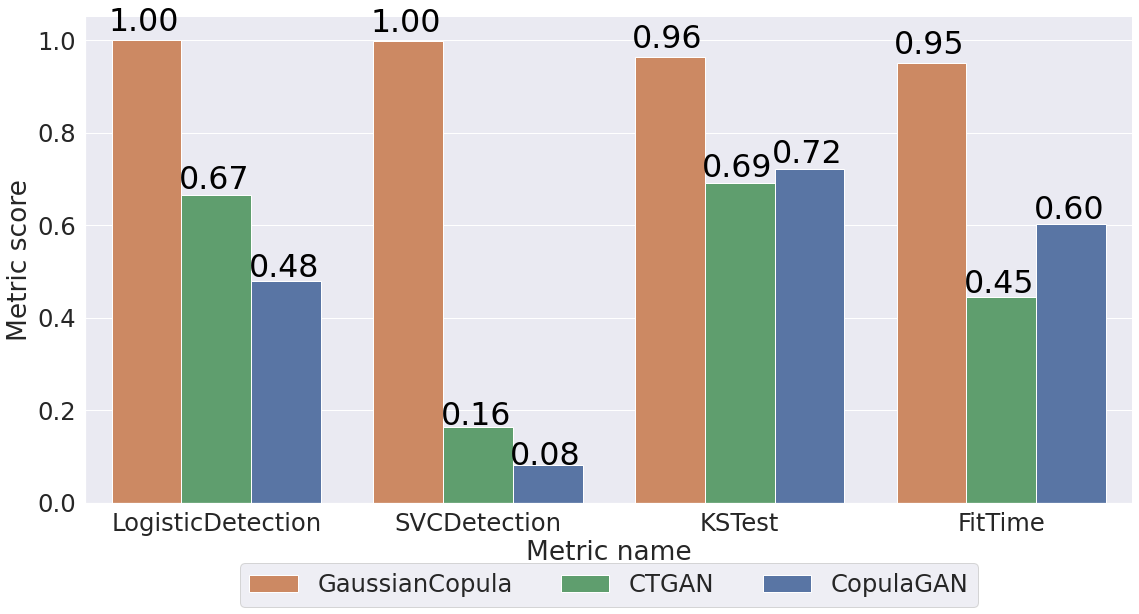

In [20]:
import matplotlib
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
rs["Model name"] = rs["model_name"]
rs["Metric score"] = rs["raw_score"]
rs["Metric name"] = rs["metric"]
rcParams['figure.figsize'] = (3, 3)
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)
sns.set(font_scale=2.2)  # crazy big
plot = sns.catplot(data=rs, x="Metric name", y="Metric score", hue="Model name", kind="bar", aspect=2, height=8, palette=[
    "C1", "C2", "C0"
], legend=False)
ax = plot.facet_axis(0,0)
hist_values = [rs.iloc[0, 2], rs.iloc[1, 2], rs.iloc[2, 2], rs.iloc[9, 2],
               rs.iloc[3, 2], rs.iloc[4, 2], rs.iloc[5, 2], rs.iloc[10, 2],
               rs.iloc[6, 2], rs.iloc[7, 2], rs.iloc[8, 2], rs.iloc[11, 2]]
for (p, val) in zip(ax.patches, hist_values):
    ax.text(p.get_x() - 0.01, 
            p.get_height() * 1.02, 
           '{:1.2f}'.format(val),   #Used to format it K representation
            color='black', 
            rotation='horizontal', 
            size='large')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, ncol=3)

In [21]:
rs_ = _comp_result_[
    (_comp_result.metric == "LogisticDetection") |
    (_comp_result.metric == "SVCDetection") |
    (_comp_result.metric == "KSTest") 
]

In [22]:
rs_=rs_.append(pd.DataFrame({'metric' : ['FitTime']*3, 
                        'raw_score' : [0.9367300581907734, 0.5739131876661848, 0.4893567541430418],
                        'model_name' : ['GaussianCopula', 'CTGAN', 'CopulaGAN']}))

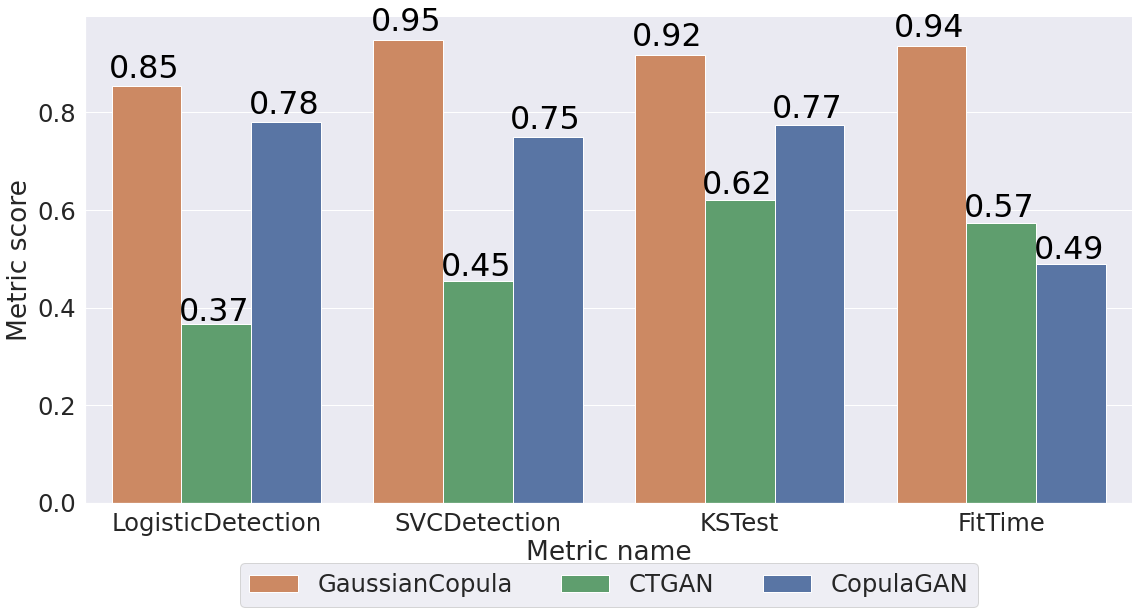

In [23]:
rs_["Model name"] = rs_["model_name"]
rs_["Metric score"] = rs_["raw_score"]
rs_["Metric name"] = rs_["metric"]
rcParams['figure.figsize'] = (3, 3)
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)
sns.set(font_scale=2.2)  # crazy big
plot = sns.catplot(data=rs_, x="Metric name", y="Metric score", hue="Model name", kind="bar", aspect=2, height=8, palette=[
    "C1", "C2", "C0"
], legend=False)
ax = plot.facet_axis(0,0)
hist_values = [rs_.iloc[0, 2], rs_.iloc[1, 2], rs_.iloc[2, 2], rs_.iloc[9, 2],
               rs_.iloc[3, 2], rs_.iloc[4, 2], rs_.iloc[5, 2], rs_.iloc[10, 2],
               rs_.iloc[6, 2], rs_.iloc[7, 2], rs_.iloc[8, 2], rs_.iloc[11, 2]]
for (p, val) in zip(ax.patches, hist_values):
    ax.text(p.get_x() - 0.01, 
            p.get_height() * 1.02, 
           '{:1.2f}'.format(val),   #Used to format it K representation
            color='black', 
            rotation='horizontal', 
            size='large')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, ncol=3)

In [25]:
from sdv.tabular import CTGAN, GaussianCopula, CopulaGAN

syn_users_generator = GaussianCopula.load(r'./validation_models/GaussianCopula_users.pkl')
syn_items_generator = CopulaGAN.load('./validation_models/CopulaGAN_items.pkl')